### In this experiment, we test the two adapted online approaches for the augmented model (27) with sythesized graphs:

We follow the testing procedure:

1. Generate a product graph (sparse in $\mathbf{A}_{\mathrm{N}}$, and $\mathbf{A}_{\mathrm{D}}$ is diagnoal matrix): $\mathbf{A} = \mathbf{A}_{\mathrm{D}} + \mathbf{A}_{\mathrm{F}} \oplus \mathbf{A}_{\mathrm{N}}$.

2. Set the length of period $M$ (e.g. $12$), generate a trend vector of length $M$ for each node and each feature.

3. Start the online procedure for both approaches: 

 2.1.  We first start appraoch $2$ as: 
  
    We generate only a *few* samples (e.g. ${t_0} = 20$) from the data model: 
    $$\Bigg\{\begin{aligned}
    \mathbf{x}_{\tau} &= \mathbf{b}_{\tau}^0 + \mathbf{x}_{\tau}^{'} \\
    \mathbf{x}_{\tau}^{'} &= \mathbf{A} \mathbf{x}_{\tau-1}^{'} + \mathbf{z}_{\tau}. 
    \end{aligned}$$ which we use to setup the batch problem with a *large* $\lambda_{t_0}$: $$\mathbf{A}({t_0}, \lambda_{t_0}) = \arg\min_{\mathbf{A} \in \mathcal{K_G}}\frac{1}{2t}\sum\limits_{m = 0}^{M-1}\sum\limits_{\tau \in I_{m,t}}\|\mathbf{x}_{\tau} - \mathbf{b}_m - \mathbf{A} \mathbf{x}_{\tau-1}\|_2^2 + \lambda_{t_0} F\|\mbox{Proj}_{\mathcal{G}_{\mathrm{N}}}(\mathbf{A})\|_1.$$ 
    We use this over sparse solution to start the online procedure $2$. Note that, $\mathbf{A}({t_0}, \lambda_{t_0})$ is far from the true $A$, so that we can wish to see a more accurate estimate $\mathbf{A}(t, \lambda_t)$ after online updating, with the updated $\lambda$ keeping decreasing.
    
 2.2. For appraoch $1$, we wait until there are enough samples (for simplicity until $t = dim(\mathcal{K_G}))$ for $\hat{\mathbf{\Gamma}}_{t}(0)$ to be invertible, then we use $[\hat{\mathbf{\Gamma}}_{t}(0)]^{-1}$ to start the online procedure $1$.

4. We perform another $500$ online iterations. we trace the performance of both approaches using metrics:
    - Average one step prediction error:
        $$\sum\limits_{\tau=1}^t\frac{\|x_{\tau+1} - \hat{\mathbf{b}}_{m(\tau+1), \tau} - \hat{\mathbf{A}}_{\tau}x_{\tau}\|_2}{t\|x_{\tau+1}\|_2}, \quad m(\tau + 1) = (\tau + 1) \; \mbox{mod} \; M$$
    - Root mean square deviation:
        $$\frac{\|\mathbf{A} - \hat{\mathbf{A}}_t\|_{\mathbf{F}}}{\|\mathbf{A}\|_{\mathbf{F}}}$$
    
    - For approach $2$, we also setup the batch problem using *all samples* and *the final $\lambda$*, and compare its solution with the last online solution of approach $2$.

## Experiment 
### Generate a random product graph

<AxesSubplot:>

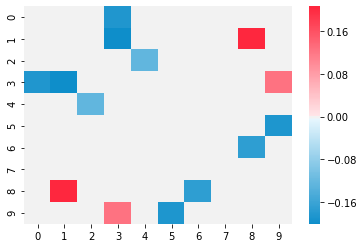

In [24]:
import matplotlib.pyplot as plt
#plt.rcParams['pdf.fonttype'] = 42
#plt.rcParams['ps.fonttype'] = 42
#plt.rcParams['text.usetex'] = True

##### GPU/CPU code control #####
import os
os.environ['GPU_use'] = 'False'

if os.environ['GPU_use'] == 'False':
    import numpy as xp
    from numpy import linalg as lg
else:
    import cupy as xp
    from cupy import linalg as lg

### Data type control ###
dtype = xp.float64
#########################

import numpy as np
from sklearn import datasets
from numpy import linalg as lg
from seaborn import heatmap as heatmap
import seaborn as sns
from utilities import *
from homotopy_algo import *

N = 10
F = 4
nnz = 7 # sparsity
D, A_N, A_F, Ax = generator_rg(N, F, nnz, dtype=dtype)

rdgn = sns.diverging_palette(h_neg=240, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
heatmap(A_N, center = 0.0, cmap = rdgn)

### Illustration of synthetic time series with periodic trends

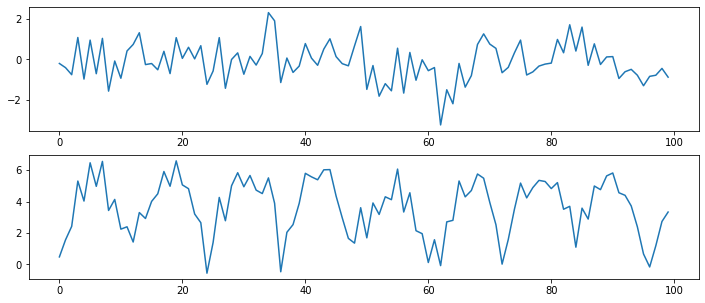

In [25]:
M = 12
b = 5*np.sin(np.arange(M)*np.math.pi/M) + np.random.normal(size = (N*F,1))
Sigma = datasets.make_spd_matrix(N*F)

# sample the obervations with trend 
x_df = np.zeros(shape = (N*F, 100))
x_df_obs = np.zeros(shape = (N*F, 100))
x_df[:,0] = np.random.normal(size = (N*F, 1)).flatten() # Initial signal
x_df_obs[:,0] = x_df[:,0] + b[:,0] # the initial obs. starts from January 
for t in np.arange(1, 100):
    x_df[:,t] = syn(x_df[:,t-1].reshape(-1,1), Ax, Sigma).flatten()
    x_df_obs[:,t] = x_df[:,t] + b[:,t % 12]

fig, ax = plt.subplots(figsize = (12,5), nrows = 2, ncols = 1)
ax[0].plot(x_df[0,:])
plt.title("First component of a sythetic stationary time series: x'_t")
ax[1].plot(x_df_obs[0,:])
plt.title("First component of a sythetic time series with the added periodic trends: x_t")

### Sample T observations $x_t$

**We now use samples with added trends as observations, and consider the bias terms $b_i$ in the model to estimate the trends and graphs at the same time**

In [26]:
# Batch problem setup
dim = int(N*F + .5*F*(F-1) + .5*N*(N-1)) # Dimension of space K
Gamma0 = np.zeros(shape = (dim, dim)) # The structured Gamma0_hat used in HomoAlgos
gamma1 = np.zeros(shape = (dim, 1)) # The structured Gamma1_hat used in HomoAlgos
Gamma0_hat, Gamma1_hat = np.zeros(shape = (N*F, N*F)), np.zeros(shape = (N*F, N*F))
Gamma0_b_hat, Gamma1_b_hat = np.zeros(shape = (N*F, N*F)), np.zeros(shape = (N*F, N*F))
p_m = np.zeros(12)  
x_lmean = np.zeros(shape = (N*F, M))
x_umean = np.zeros(shape = (N*F, M))
x_old = np.random.normal(size = (N*F, 1)) # Initial hidden signal 
x_old_obs = x_old + b[:,0].reshape(-1,1) # Initial observed signal in January

T = 20

for t in np.arange(1, T + 1):
    m = t % 12 # current month
    p_m[m] = p_m[m] + 1 
    x_new = syn(x_old, Ax, Sigma)  
    x_new_obs = x_new + b[:,m].reshape(-1,1)
    
    # estimation of monthly means
    x_umean[:,m] = (p_m[m]-1)*x_umean[:,m]/p_m[m] + x_new_obs.flatten()/p_m[m]
    x_lmean[:,m-1] = (p_m[m]-1)*x_lmean[:,m-1]/p_m[m] + x_old_obs.flatten()/p_m[m]

    Gamma0_b_hat = (t-1)*Gamma0_b_hat/t + x_old_obs.dot(x_old_obs.T)/t
    Gamma1_b_hat = (t-1)*Gamma1_b_hat/t + x_new_obs.dot(x_old_obs.T)/t 
    
    X_old_obs = node_mat(N, F, x_old_obs)
    Gamma0 = (t-1)*Gamma0/t + X_old_obs.dot(X_old_obs.T)/t
    gamma1 = (t-1)*gamma1/t + X_old_obs.dot(x_new_obs)/t
    
    x_old = x_new.copy()
    x_old_obs = x_new_obs.copy()
    
Gamma0_hat = Gamma0_b_hat - np.dot(x_lmean[:,np.arange(M)-1]*p_m, x_lmean[:,np.arange(M)-1].T)/t
Gamma1_hat = Gamma1_b_hat - np.dot(x_umean*p_m, x_lmean[:,np.arange(M)-1].T)/t
for m in range(M) :
    X_lmean = node_mat(N, F, x_lmean[:,m-1])
    Gamma0 = Gamma0 - p_m[m]*X_lmean.dot(X_lmean.T)/t
    gamma1 = gamma1 - p_m[m]*X_lmean.dot(x_umean[:,m].reshape(-1,1))/t

#### Start the online procedure 2

In [27]:
# Proximal gradient descent
start_time2 = time.time()
D_hat, A_N_hat, A_F_hat = xp.zeros((N,F), dtype), xp.zeros((N,N), dtype), xp.zeros((F,F), dtype)
lambda_0 = xp.float64(5e-2).astype(dtype)
epsilon = xp.float64(1e-5).astype(dtype)
D_hat, A_N_hat, A_F_hat, n = PGD_gl(D_hat, A_N_hat, A_F_hat, Gamma0_hat, Gamma1_hat, lambda_0, epsilon, verbose = False)
A_hat = xp.diag(D_hat.ravel(order = 'F')) + xp.kron(A_F_hat, xp.eye(N, dtype = dtype)) + xp.kron(xp.eye(F, dtype = dtype), A_N_hat)   
m = (t+1) % M
b_hat_next = x_umean[:,m] - A_hat.dot(x_lmean[:,m-1])
end_time2 = time.time()
A_hat_init = A_hat.copy()
print(end_time2 - start_time2)

0.8021450042724609


<AxesSubplot:>

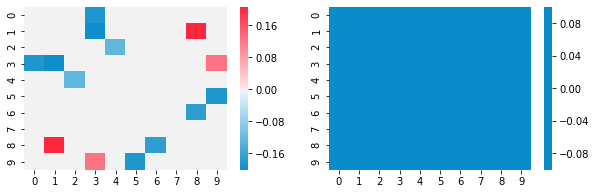

In [28]:
fig, ax = plt.subplots(figsize=[10,3], nrows=1, ncols=2)
heatmap(A_N, center = 0.0, cmap = rdgn, ax=ax[0])
heatmap(A_N_hat, center = 0.0, cmap = rdgn, ax=ax[1])

The batch solution $\mathbf{A}_{\mathrm{N}}(0, \lambda_0)$ from large $\lambda_0$ is oversparse compared to the true $\mathbf{A}_{\mathrm{N}}$.

In [29]:
# Prepare the input of homotopy algorithms and the regularization parameter tuning procedure
dim_DF = int(N*F + .5*F*(F-1))
iuN = triu_indices(N)
iuF = triu_indices(F)
nz = np.where(A_N_hat[iuN] != 0)[0]
z = np.where(A_N_hat[iuN] == 0)[0]
wN1 = xp.sign(A_N_hat[iuN][nz])
KN1 = (nz + dim_DF).tolist()
K1 = list(range(dim_DF)) + KN1
w1 = xp.concatenate((xp.zeros(dim_DF, dtype),wN1))
iGamma01 = np.linalg.inv(Gamma0[np.ix_(K1,K1)])

In [30]:
# Initialize the error metrics
eta = xp.float64(5e-6).astype(dtype) # step size for lambda updating
lambda_max = xp.float64(0.1).astype(dtype) 
lambda_old = lambda_0
lambda_update_list = []
lambda_trans_list = []
mu_trans_list = []
pred_err_list = []
pred_err_wald_list = []
err_l2 = []
err_l2_wald = []
run_time = []
run_time_wald = []

In [31]:
# Online iterations 
# From now on we only need <<x_lmean>>
while t <= (dim-1):
    m = (t+1) % M # current month    
    x_new = syn(x_old, Ax, Sigma)  
    x_new_obs = x_new + b[:,m].reshape(-1,1)

    pred_err = np.linalg.norm(A_hat.dot(x_old_obs) + b_hat_next - x_new_obs)/np.linalg.norm(x_new_obs)
    pred_err_list.append(pred_err)
    pred_err_wald_list.append(xp.nan)
    
    # approach 2: 
    tic = time.time()
    
    # step 1: update lambda using SGD 
    G_b = A_hat.dot(x_old_obs) + b_hat_next.reshape(-1,1) - x_new_obs
    lambda_new = lambda_update_b(N, F, KN1, iGamma01, wN1, G_b, x_old_obs, x_lmean[:,m-1], lambda_old, lambda_max, eta)
    #print("New lambda: {}\n".format(lambda_new))
    lambda_update_list.append(lambda_new)

    if lambda_old != (1+1/t)*lambda_new:
    # step 2: change lambda_old to (1+1/t)*lambda_new in the old problem ((1+1/t)*: for changing lambda and the normalization constant before data term at the same time)
    ## Homotopy algorithm 1
        _, KN1, iGamma01, wN1, lambda_trans = lambda_path(N, F, Gamma0, gamma1, KN1, wN1, lambda_old, (1+1/t)*lambda_new, iGamma01)
        lambda_trans_list.append(lambda_trans)
    
    # step 3: keep lambda_new unchanged in the problem, add new sample
    ## Homotopy algorithm 2    
    x_new_c = x_new_obs - x_lmean[:,m].reshape(-1,1)
    X_old_c = node_mat(N, F, x_old_obs.flatten() - x_lmean[:,m-1])
    as1, KN1, iGamma01, wN1, Gamma0, gamma1, mu_trans = new_data_path(N, F, iGamma01, KN1, wN1, Gamma0, gamma1, lambda_new, x_new_c, X_old_c, t, p_m[m])
    mu_trans_list.append(mu_trans)
    
    ## retrieve matrices from their vectorized version
    D_hat, A_N_hat, A_F_hat = as1_A(N, F, as1, KN1)
    A_hat = np.diag(D_hat.flatten(order = 'F')) + np.kron(A_F_hat, np.eye(N)) + np.kron(np.eye(F), A_N_hat)    
    err_l2.append(np.linalg.norm(A_hat - Ax)/np.linalg.norm(Ax))
    err_l2_wald.append(xp.nan)
    
    toc = time.time()
    run_time.append(toc-tic)
    run_time_wald.append(xp.nan)
    
    Gamma0_hat = t*Gamma0_hat/(t+1) + p_m[m]*np.dot(x_old_obs - x_lmean[:,m-1].reshape(-1,1), x_old_obs.T - x_lmean[:,m-1].reshape(1,-1))/(t+1)/(p_m[m]+1)
    Gamma1_hat = t*Gamma1_hat/(t+1) + p_m[m]*np.dot(x_new_obs - x_lmean[:,m].reshape(-1,1), x_old_obs.T - x_lmean[:,m-1].reshape(1,-1))/(t+1)/(p_m[m]+1)
               
    t += 1   
    p_m[m] = p_m[m] + 1    
    x_lmean[:,m-1] = (p_m[m]-1)*x_lmean[:,m-1]/p_m[m] + x_old_obs.flatten()/p_m[m]
    m = (t+1) % M # next month    
    b_hat_next = x_lmean[:,m] - A_hat.dot(x_lmean[:,m-1])
    
    lambda_old = lambda_new
    x_old = x_new.copy()
    x_old_obs = x_new_obs.copy()

#### Start the online procedure 1

In [32]:
start_time1 = time.time()
Gamma0_hat_inv = xp.linalg.inv(Gamma0_hat) #initialize the inverse
A_ls = Gamma1_hat.dot(Gamma0_hat_inv)

A_N_hat_wald = proj_N(A_ls, N = N, F = F)
A_F_hat_wald = proj_F(A_ls, N = N, F = F)
    
# Wald test
Sigma_hat = Gamma0_hat - Gamma1_hat.dot(Gamma0_hat_inv).dot(Gamma1_hat.T)
A_N_hat_wald, _, _ = wald_test(n = t, A_N_hat = A_N_hat_wald, Gamma0_hat_inv = Gamma0_hat_inv, Sigma_hat = Sigma_hat)
A_hat_wald = Kron_str(xp.diag(A_ls).reshape(N,F,order = 'F'), A_N_hat_wald, A_F_hat_wald)
m = (t+1) % M
b_hat_next_wald = x_lmean[:,m] - A_ls.dot(x_lmean[:,m-1])
end_time1 = time.time()
A_hat_wald_init = A_hat_wald.copy()
print(end_time1 - start_time1)

0.7975630760192871


The solutions at t = 91.


[Text(0.5, 1.0, 'Lasso')]

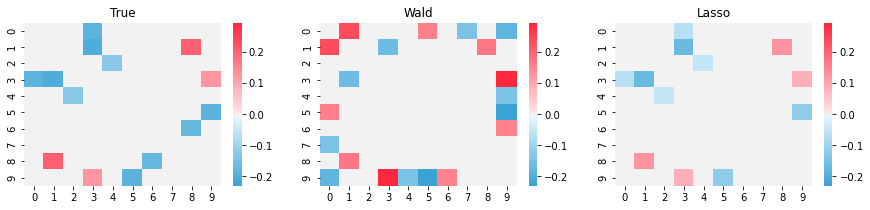

In [33]:
fig, ax = plt.subplots(figsize=[15,3], nrows=1, ncols=3)
print("The solutions at t = {}.".format(t))
vmin = min(xp.min(A_N), xp.min(A_N_hat), xp.min(A_N_hat_wald))
vmax = max(xp.max(A_N), xp.max(A_N_hat), xp.max(A_N_hat_wald))
heatmap(A_N, center = 0.0, vmin = vmin, vmax = vmax, cmap = rdgn, ax=ax[0])
ax[0].set(title='True')
heatmap(A_N_hat_wald, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[1])
ax[1].set(title='Wald')
heatmap(A_N_hat, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[2])
ax[2].set(title='Lasso')

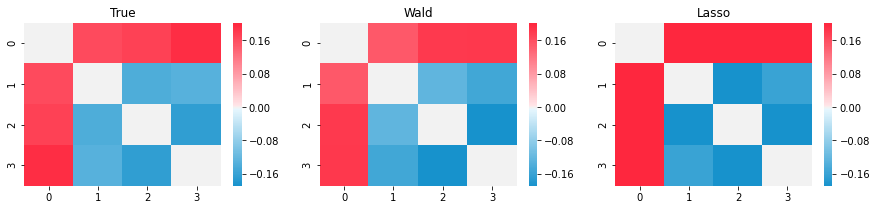

In [55]:
fig, ax = plt.subplots(figsize=[15,3], nrows=1, ncols=3)
vmin = min(xp.min(A_F), xp.min(A_F_hat), xp.min(A_F_hat_wald))
vmax = max(xp.max(A_F), xp.max(A_F_hat), xp.max(A_F_hat_wald))
heatmap(A_F, center = 0.0, vmin = vmin, vmax = vmax, cmap = rdgn, ax=ax[0])
ax[0].set(title='True')
heatmap(A_F_hat_wald, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[1])
ax[1].set(title='Wald')
heatmap(proj_F(A_hat_init, N = N, F = F), vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[2])
ax[2].set(title='Lasso')
fig.savefig("Est_init_AF_aug.pdf", bbox_inches='tight')

The solutions at t = 91.


[Text(0.5, 1.0, 'Estimated at t = 91'), Text(0.5, 0, 'Month')]

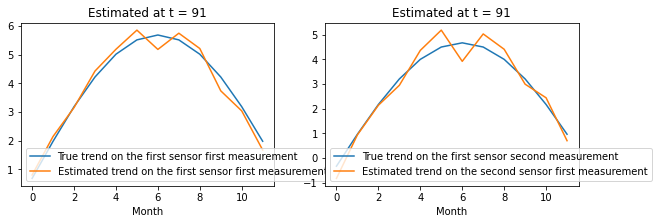

In [35]:
fig, ax = plt.subplots(figsize=[10,3], nrows=1, ncols=2)
print("The solutions at t = {}.".format(t))
ax[0].plot(b[0,:], label = "True trend on the first sensor first measurement")
ax[0].plot(x_lmean[0,:], label = "Estimated trend on the first sensor first measurement")
ax[0].legend()
ax[0].set(title = "Estimated at t = {}".format(t), xlabel = "Month")

ax[1].plot(b[1,:], label = "True trend on the first sensor second measurement")
ax[1].plot(x_lmean[1,:], label = "Estimated trend on the second sensor first measurement")
ax[1].legend()
ax[1].set(title = "Estimated at t = {}".format(t), xlabel = "Month")

### Online iterations

In [36]:
# Online iterations 
for n in range(500):
    if n % 50 == 0: print(n)
    m = (t+1) % M # current month    
    x_new = syn(x_old, Ax, Sigma)  
    x_new_obs = x_new + b[:,m].reshape(-1,1)

    pred_err = np.linalg.norm(A_hat.dot(x_old_obs) + b_hat_next - x_new_obs)/np.linalg.norm(x_new_obs)
    pred_err_list.append(pred_err)
    pred_err_wald = np.linalg.norm(A_hat_wald.dot(x_old_obs) + b_hat_next_wald - x_new_obs)/np.linalg.norm(x_new_obs)
    pred_err_wald_list.append(pred_err_wald)
    
    # approach 2: 
    tic = time.time()
    
    # step 1: update lambda using SGD 
    G_b = A_hat.dot(x_old_obs) + b_hat_next.reshape(-1,1) - x_new_obs
    lambda_new = lambda_update_b(N, F, KN1, iGamma01, wN1, G_b, x_old_obs, x_lmean[:,m-1], lambda_old, lambda_max, eta)
    #print("New lambda: {}\n".format(lambda_new))
    lambda_update_list.append(lambda_new)

    if lambda_old != (1+1/t)*lambda_new:
    # step 2: change lambda_old to (1+1/t)*lambda_new in the old problem ((1+1/t)*: for changing lambda and the normalization constant before data term at the same time)
    ## Homotopy algorithm 1
        _, KN1, iGamma01, wN1, lambda_trans = lambda_path(N, F, Gamma0, gamma1, KN1, wN1, lambda_old, (1+1/t)*lambda_new, iGamma01)
        lambda_trans_list.append(lambda_trans)
    
    # step 3: keep lambda_new unchanged in the problem, add new sample
    ## Homotopy algorithm 2    
    x_new_c = x_new_obs - x_lmean[:,m].reshape(-1,1)
    X_old_c = node_mat(N, F, x_old_obs.flatten() - x_lmean[:,m-1])
    as1, KN1, iGamma01, wN1, Gamma0, gamma1, mu_trans = new_data_path(N, F, iGamma01, KN1, wN1, Gamma0, gamma1, lambda_new, x_new_c, X_old_c, t, p_m[m])
    mu_trans_list.append(mu_trans)
    
    ## retrieve matrices from their vectorized version
    D_hat, A_N_hat, A_F_hat = as1_A(N, F, as1, KN1)
    A_hat = np.diag(D_hat.flatten(order = 'F')) + np.kron(A_F_hat, np.eye(N)) + np.kron(np.eye(F), A_N_hat)    
    err_l2.append(np.linalg.norm(A_hat - Ax)/np.linalg.norm(Ax))
    
    toc = time.time()
    run_time.append(toc-tic)
    
    
    # approach 1: 
    tic = time.time()
    
    Gamma0_hat = t*Gamma0_hat/(t+1) + p_m[m]*np.dot(x_old_obs - x_lmean[:,m-1].reshape(-1,1), x_old_obs.T - x_lmean[:,m-1].reshape(1,-1))/(t+1)/(p_m[m]+1)
    Gamma1_hat = t*Gamma1_hat/(t+1) + p_m[m]*np.dot(x_new_obs - x_lmean[:,m].reshape(-1,1), x_old_obs.T - x_lmean[:,m-1].reshape(1,-1))/(t+1)/(p_m[m]+1)

    Gamma0_hat_inv = Gamma0_hat_inv*(t+1)/t
    scale = t*(1+(1/p_m[m])) + np.dot(x_old_obs.T - x_lmean[:,m-1].reshape(-1,1).T, Gamma0_hat_inv.dot(x_old_obs - x_lmean[:,m-1].reshape(-1,1)))
    scale = t*scale/(t+1)
    Gamma0_hat_inv = Gamma0_hat_inv - \
        Gamma0_hat_inv.dot(x_old_obs - x_lmean[:,m-1].reshape(-1,1)).dot(x_old_obs.T - x_lmean[:,m-1].reshape(-1,1).T).dot(Gamma0_hat_inv)/scale
    
    A_ls = Gamma1_hat.dot(Gamma0_hat_inv)          
    A_N_hat_wald = proj_N(A_ls, N = N, F = F)
    A_F_hat_wald = proj_F(A_ls, N = N, F = F)
    
    # Wald test
    Sigma_hat = Gamma0_hat - Gamma1_hat.dot(Gamma0_hat_inv).dot(Gamma1_hat.T)
    A_N_hat_wald, _, _ = wald_test(n = t+1, A_N_hat = A_N_hat_wald, Gamma0_hat_inv = Gamma0_hat_inv, Sigma_hat = Sigma_hat)
    A_hat_wald = xp.diag(np.diag(A_ls)) + xp.kron(A_F_hat_wald, xp.eye(N, dtype = dtype)) + xp.kron(xp.eye(F, dtype = dtype), A_N_hat_wald)   
    err_l2_wald.append(xp.linalg.norm(A_hat_wald - Ax)/xp.linalg.norm(Ax))
           
    toc = time.time()
    run_time_wald.append(toc-tic)
           
    t += 1   
    p_m[m] = p_m[m] + 1    
    
    x_lmean[:,m-1] = (p_m[m]-1)*x_lmean[:,m-1]/p_m[m] + x_old_obs.flatten()/p_m[m]
    m = (t+1) % M # next month    
    b_hat_next = x_lmean[:,m] - A_hat.dot(x_lmean[:,m-1])
    b_hat_next_wald = x_lmean[:,m] - A_ls.dot(x_lmean[:,m-1])
    
    lambda_old = lambda_new
    x_old = x_new.copy()
    x_old_obs = x_new_obs.copy()
    
    if t == 2*dim:
        A_N_hat_2d = A_N_hat.copy()
        A_N_hat_wald_2d = A_N_hat_wald.copy()
        A_F_hat_2d = A_F_hat.copy()
        A_F_hat_wald_2d = A_F_hat_wald.copy()
        x_lmean_2d = x_lmean.copy()
    if t == 3*dim:
        A_N_hat_3d = A_N_hat.copy()
        A_N_hat_wald_3d = A_N_hat_wald.copy()
        A_F_hat_3d = A_F_hat.copy()
        A_F_hat_wald_3d = A_F_hat_wald.copy()
        x_lmean_3d = x_lmean.copy()

0
50
100
150
200
250
300
350
400
450


**Error metrics and the regularization parameter evolution**

[Text(0.5, 1.0, 'Regularization parameter evolution'),
 Text(0.5, 0, 'Iteration')]

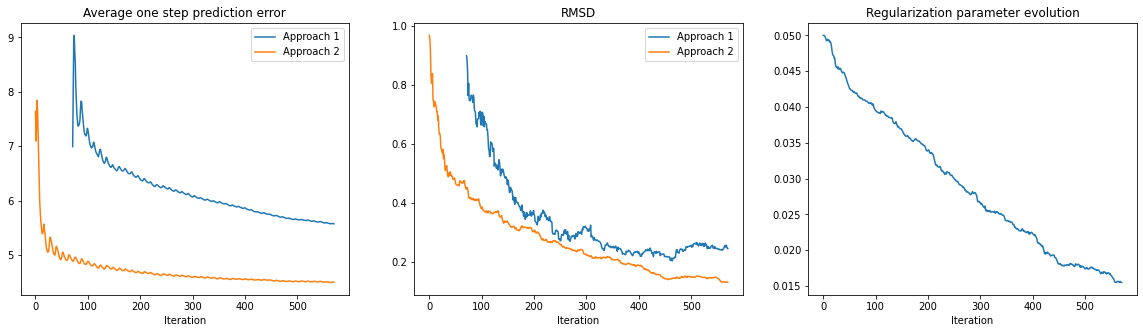

In [37]:
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(figsize=[20,5], nrows=1, ncols=3)
ax[0].plot([np.nanmean(pred_err_wald_list[:k]) for k in range(1,len(pred_err_list)+1)], label = "Approach 1")
ax[0].plot([np.mean(pred_err_list[:k]) for k in range(1,len(pred_err_list)+1)], label = "Approach 2")
ax[0].set(title = 'Average one step prediction error', xlabel = "Iteration")
ax[0].legend()

ax[1].plot(err_l2_wald, label = "Approach 1")
ax[1].plot(err_l2, label = "Approach 2")
ax[1].set(title = 'RMSD', xlabel = "Iteration")
ax[1].legend()

ax[2].plot(lambda_update_list)
ax[2].set(title = 'Regularization parameter evolution', xlabel = "Iteration")

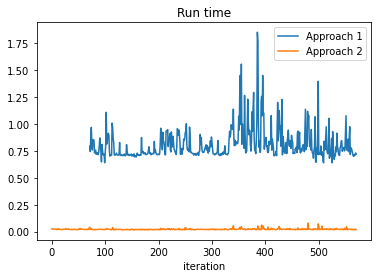

In [38]:
#f = plt.figure()
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(run_time_wald, label = "Approach 1")
plt.plot(run_time, label = "Approach 2")
plt.title('Run time')
plt.xlabel("iteration")
plt.legend()
#f.savefig("run_time.pdf", bbox_inches='tight')

### True sensor graph (left) compared with the online solutions of approach 1 (middle), and the online solutions of approach 2 (right) from different online iterations

The online solutions at t = 182


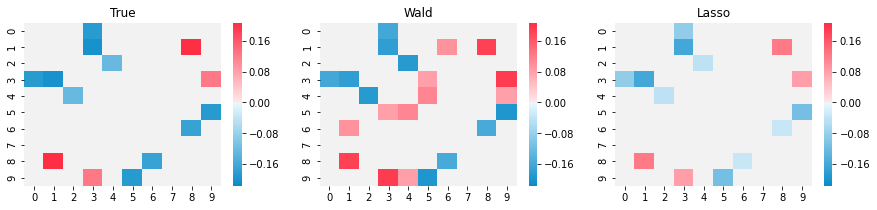

In [58]:
fig, ax = plt.subplots(figsize=[15,3], nrows=1, ncols=3)
print("The online solutions at t = {}".format(2*dim))
vmin = min(xp.min(A_N), xp.min(A_N_hat), xp.min(A_N_hat_wald))
vmax = max(xp.max(A_N), xp.max(A_N_hat), xp.max(A_N_hat_wald))
heatmap(A_N, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[0])
ax[0].set(title='True')
heatmap(A_N_hat_wald_2d, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[1])
ax[1].set(title='Wald')
heatmap(A_N_hat_2d, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[2])
ax[2].set(title='Lasso')
fig.savefig("Est_2d_aug.pdf", bbox_inches='tight')

The online solutions at t = 273


[Text(0.5, 1.0, 'Lasso')]

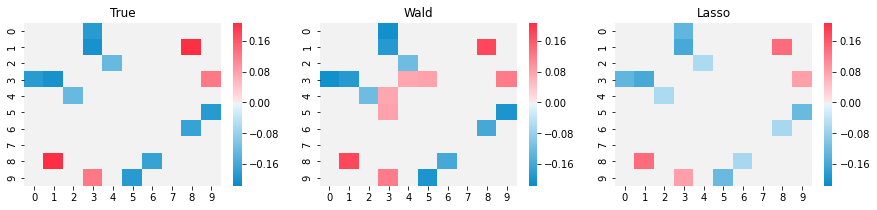

In [40]:
fig, ax = plt.subplots(figsize=[15,3], nrows=1, ncols=3)
print("The online solutions at t = {}".format(3*dim))
vmin = min(xp.min(A_N), xp.min(A_N_hat), xp.min(A_N_hat_wald))
vmax = max(xp.max(A_N), xp.max(A_N_hat), xp.max(A_N_hat_wald))
heatmap(A_N, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[0])
ax[0].set(title='True')
heatmap(A_N_hat_wald_3d, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[1])
ax[1].set(title='Wald')
heatmap(A_N_hat_3d, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[2])
ax[2].set(title='Lasso')

The online solutions at t = 591


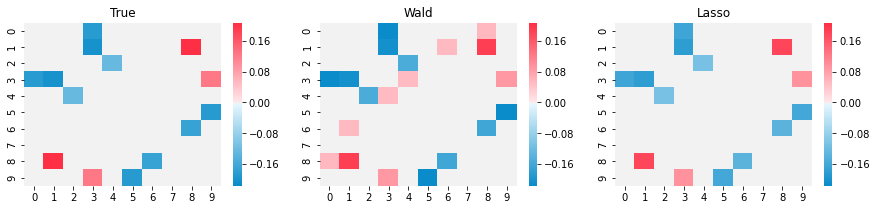

In [61]:
fig, ax = plt.subplots(figsize=[15,3], nrows=1, ncols=3)
print("The online solutions at t = {}".format(t))
vmin = min(xp.min(A_N), xp.min(A_N_hat), xp.min(A_N_hat_wald))
vmax = max(xp.max(A_N), xp.max(A_N_hat), xp.max(A_N_hat_wald))
heatmap(A_N, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[0])
ax[0].set(title='True')
heatmap(A_N_hat_wald, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[1])
ax[1].set(title='Wald')
heatmap(A_N_hat, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[2])
ax[2].set(title='Lasso')
fig.savefig("Est_591_aug.pdf", bbox_inches='tight')

The online solutions at t = 591


[Text(0.5, 1.0, 'Lasso')]

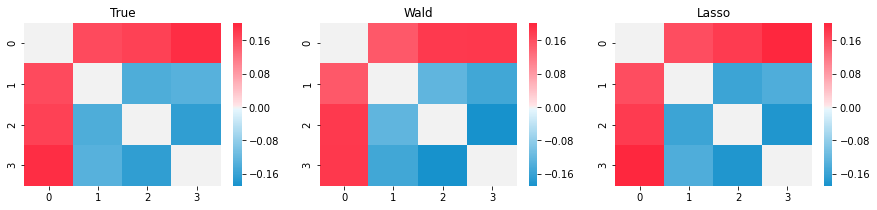

In [42]:
fig, ax = plt.subplots(figsize=[15,3], nrows=1, ncols=3)
print("The online solutions at t = {}".format(t))
vmin = min(xp.min(A_F), xp.min(A_F_hat), xp.min(A_F_hat_wald))
vmax = max(xp.max(A_F), xp.max(A_F_hat), xp.max(A_F_hat_wald))
heatmap(A_F, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[0])
ax[0].set(title='True')
heatmap(A_F_hat_wald, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[1])
ax[1].set(title='Wald')
heatmap(A_F_hat, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn, ax=ax[2])
ax[2].set(title='Lasso')

**Setup the final batch problem with all obs. and last lambda, compare with the last online solution**

<AxesSubplot:>

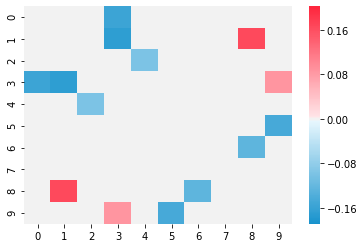

In [43]:
D_hat_bth, A_N_hat_bth, A_F_hat_bth = xp.zeros((N,F), dtype), xp.zeros((N,N), dtype), xp.zeros((F,F), dtype)
epsilon = xp.float64(1e-5).astype(dtype)
D_hat_bth, A_N_hat_bth, A_F_hat_bth, n = PGD_gl(D_hat_bth, A_N_hat_bth, A_F_hat_bth, Gamma0_hat, Gamma1_hat, lambda_new, epsilon, verbose = False)
plt.figure()
heatmap(A_N_hat_bth, vmin = vmin, vmax = vmax, center = 0.0, cmap = rdgn)

### Estimated trends (same for two approaches) from different online iterations

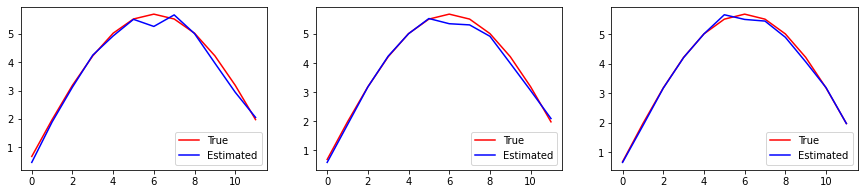

In [56]:
fig, ax = plt.subplots(figsize=[15,3], nrows=1, ncols=3)
ax[0].plot(b[0,:], label = "True", color = "red")
ax[0].plot(x_lmean_2d[0,:], label = "Estimated", color = "blue")
ax[0].legend()
#ax[0].set(title = "Estimated at t = {}".format(2*dim), xlabel = "Month")

ax[1].plot(b[0,:], label = "True", color = "red")
ax[1].plot(x_lmean_3d[0,:], label = "Estimated", color = "blue")
ax[1].legend()
#ax[1].set(title = "Estimated at t = {}".format(3*dim), xlabel = "Month")

ax[2].plot(b[0,:], label = "True", color = "red")
ax[2].plot(x_lmean[0,:], label = "Estimated", color = "blue")
ax[2].legend()
#ax[2].set(title = "Estimated at t = {}".format(t), xlabel = "Month")
fig.savefig("Est_trend.pdf", bbox_inches='tight')

[Text(0.5, 1.0, 'Estimated at t = 591'), Text(0.5, 0, 'Month')]

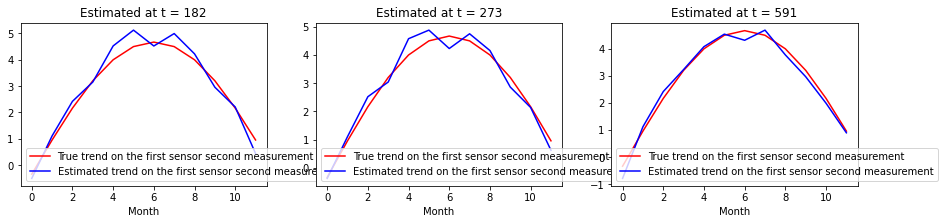

In [52]:
fig, ax = plt.subplots(figsize=[15,3], nrows=1, ncols=3)
ax[0].plot(b[1,:], label = "True trend on the first sensor second measurement", color = "red")
ax[0].plot(x_lmean_2d[1,:], label = "Estimated trend on the first sensor second measurement", color = "blue")
ax[0].legend()
ax[0].set(title = "Estimated at t = {}".format(2*dim), xlabel = "Month")

ax[1].plot(b[1,:], label = "True trend on the first sensor second measurement", color = "red")
ax[1].plot(x_lmean_3d[1,:], label = "Estimated trend on the first sensor second measurement", color = "blue")
ax[1].legend()
ax[1].set(title = "Estimated at t = {}".format(3*dim), xlabel = "Month")

ax[2].plot(b[1,:], label = "True trend on the first sensor second measurement", color = "red")
ax[2].plot(x_lmean[1,:], label = "Estimated trend on the first sensor second measurement", color = "blue")
ax[2].legend()
ax[2].set(title = "Estimated at t = {}".format(t), xlabel = "Month")